In [8]:
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
# import os.path
from pathlib import Path
from sentence_transformers import SentenceTransformer
import regex # allows alternatives in negative lookarounds
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.cluster import KMeans

# from corpus_characterization_utils import *

sys.path.append('misc/')
from utils import utils
# from ThoughtGrapher import ThoughtGrapher

# tgraph = ThoughtGrapher()



In [ ]:
SENTENCE_TRANSFORMER_MODEL_NAME = 'all-MiniLM-L6-v2'


DATA_FILE = f'dolly_data_{SENTENCE_TRANSFORMER_MODEL_NAME}.parquet' # 'dolly_data_all-mpnet-base-v2.parquet'

if Path(DATA_FILE).exists():
    dolly_data = pd.read_parquet(DATA_FILE).rename(columns={
        'inst_A':'instruction_A', 'inst_B':'instruction_B',
        'resp_A':'response_A', 'resp_B': 'response_B',
    })
else:
    model = SentenceTransformer(f'sentence-transformers/{SENTENCE_TRANSFORMER_MODEL_NAME}')
    dolly_data = model.encode()

dolly_data      

In [2]:

MODELS_FILE = f'aspect_models_LogisticRegressionCV_{SENTENCE_TRANSFORMER_MODEL_NAME}.pkl'

# Prefixing patterns by r'\b' ensures they must be at the beginning of a word. 
# This way 'eat' does not match 'great', and most plurals will be OK.
patterns = { 
    # domains
    'cars': r"\b(automobile|car|Toyota|Ford|Dodge|Jeep|Fiat)",
    'animals': r"\b(animal|cat|dog|pet)",
    'food': r"\b(food|diet|eat|restaurant)",
    'programming_language': r"\bprogramming language",
    'sports': r'\baseball(?!: bat)|basketball|badminton|tennis(?!: shoe)|soccer|futbol|football (?!: stadium)',
    'science': r"(?<![:?])(?<!(computer|political|data)) science (?!fiction)|biology|(?<!blood )chemistry|physics|astromony",
    'science_fiction': r"science fiction",
    'data_science': r"data science|machine learning|statistic|quantitative|probability|artificial intelligence|AI\b",
    'information_technology': r"technology|software|information|open source|spark",
    'books': r"\b(book(?!: a )|books|novel|literature|literary)\b",  # 'book' but not 'book a flight'

    # tasks
    'identify': r'identify|classify|which',
    'how_does': r'how (do|does)\b',
    'why_is': r'why (is|are)',
    'what is': r'what (is|are)',
    'extract': r'extract ([^:.?]+) from',
    
    # instruction structure
    'of_the_following': r'of the following',
    'given_text': r"\b(given a|given the|the given|based on|reference text|as a reference|the following text)",  # passage|paragraph
    'alternatives': r',|\b(or)\b',

    # output format
    'output_format': r"(display|the results|as a (bulleted )?list|list them|format this|format them|in the format|each record|new line|comma separated|separated by|separate them with a comma|JSON|XML|markdown)", 
}


if os.path.exists(MODELS_FILE):
    models = pickle.load( open(MODELS_FILE, 'rb') )

else:
    models = {}
    
    for text_col in ['instruction', 'response']:
        vector_col = text_col + "_vector"
        l1_ratios = [0.01, 0.1, 0.5]
        X = [v for v in dolly_data[vector_col]]
        for topic in patterns.keys():
            pattern = patterns[topic]
            flags = [bool(regex.search(pattern, sent, regex.IGNORECASE)) for sent in dolly_data[text_col]]
            # clf = LogisticRegression(C=1, max_iter=10000)
            clf = LogisticRegressionCV(cv=5, scoring='roc_auc', # fit_intercept=False, 
                                       n_jobs=-1, max_iter=10000)
            # clf = LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=l1_ratios, scoring='roc_auc', max_iter=10000)
            clf.fit(X, flags)
            flag_col = text_col + '_' + topic
            score_col = flag_col + '_score'
            models[flag_col] = {'model': clf, 'flags': flags, 'scores': clf.predict_proba(X)[:,1]}
            # dolly_data[flag_col] = flags
            # dolly_data[score_col] = clf.predict_proba(X)[:,1]
    
    pickle.dump(models, open(MODELS_FILE, 'wb'))


for flag_col in models.keys():
    model_info = models[flag_col]
    dolly_data[flag_col] = model_info['flags']
    score_col = flag_col + '_score'
    dolly_data[score_col] = model_info['scores']

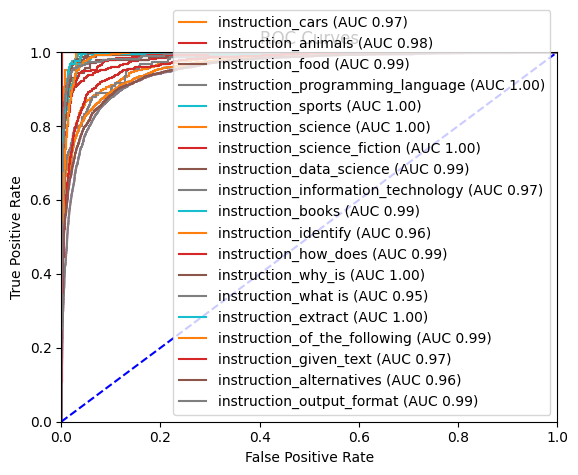

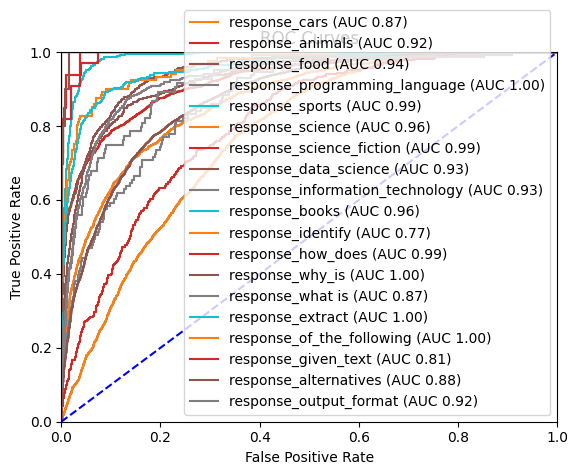

In [3]:
# list( models.keys() )

def plot_multiple_ROC_curves(score_flag_dict):
    plt.title('ROC Curves')
    for target in score_flag_dict.keys():
        model_info = score_flag_dict[target]
        fpr, tpr, threshold = metrics.roc_curve(model_info['flags'], model_info['scores'])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr)
        plt.plot(fpr, tpr, #'b', 
                 label = f'{target} (AUC {roc_auc:0.2f})')

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_multiple_ROC_curves({k:dict for k,dict in models.items() if k.startswith('instruction')})

plot_multiple_ROC_curves({k:dict for k,dict in models.items() if k.startswith('response')})

In [4]:
def get_model_stats(my_models):
    all_models_stats = []
    for topic in my_models:
        my_stats = {}
        model = my_models[topic]['model']
        cv_scores = [ max(vc) for vc in model.scores_[True] ]  # (n_folds, n_cs)
        my_stats['topic'] = topic
        my_stats['number_of_cases'] = np.sum(my_models[topic]['flags'])
        my_stats['cv_auc_mean'] = np.mean(cv_scores)
        my_stats['intercept'] = model.intercept_[0]
        my_stats['coef_std'] = np.std(model.coef_[0])
        my_stats['coef_min'] = np.min(model.coef_[0])
        my_stats['coef_mean'] = np.mean(model.coef_[0])
        my_stats['coef_max'] = np.max(model.coef_[0])
        all_models_stats.append(my_stats)
        
    return pd.DataFrame(all_models_stats)


model_stats = get_model_stats(models)
model_stats

,topic,number_of_cases,cv_auc_mean,intercept,coef_std,coef_min,coef_mean,coef_max
0,instruction_cars,536,0.901369,-5.514938,2.870177,-7.915646,-3.483665e-01,9.054671
1,instruction_animals,694,0.959107,-4.444007,1.505176,-3.728922,-6.013031e-02,4.686525
2,instruction_food,233,0.980549,-6.481981,1.177250,-3.876871,3.700957e-03,4.252732
3,instruction_programming_language,24,0.999933,-16.873609,2.216473,-5.975073,3.331303e-02,7.623810
4,instruction_sports,343,0.986970,-6.617523,1.268126,-3.896551,-4.271812e-02,3.833336
5,instruction_science,21,0.981805,-6.571004,0.002937,-0.009120,9.732552e-06,0.009874
6,instruction_science_fiction,17,0.989774,-8.047238,0.607449,-1.823362,4.008987e-04,1.415780
7,instruction_data_science,141,0.901828,-7.590975,2.574285,-7.324217,-1.670508e-01,7.932527
8,instruction_information_technology,155,0.882749,-5.403396,1.113617,-3.395230,-2.122882e-02,3.174848
9,instruction_books,218,0.991034,-5.098919,0.568549,-1.801276,4.142023e-03,1.742671


In [5]:
target_model = 'instruction_sports'
vector_col = 'instruction_vector'

clf = models[target_model]['model']

dd2 = utils.add_cluster_cols(dolly_data, embedding_col='instruction_vector', prefix='unweighted_cl', letters='A', max_threshold=10)
dd2['score'] = clf.predict_proba( X = [v for v in dolly_data[vector_col]] )[:,1]
dd2['weighted_instruction_vector'] = [ v * clf.coef_[0] for v in dolly_data[vector_col]]
dd2['inverse_weighted_instruction_vector'] = [ v / clf.coef_[0] for v in dolly_data[vector_col]]

# dd2 = utils.add_cluster_cols(dd2, embedding_col='weighted_instruction_vector', prefix='weighted_cl', letters='AB', max_threshold=10)
# dd2 = utils.add_cluster_cols(dd2, embedding_col='inverse_weighted_instruction_vector', prefix='inverse_weighted_cl', letters='AB', max_threshold=10)


In [23]:
def get_cluster_stats(df, cluster_col, score_col):
    return df.groupby(cluster_col).agg(
        score_mean=pd.NamedAgg(column=score_col, aggfunc='mean'), 
        score_std =pd.NamedAgg(column=score_col, aggfunc='std')
    ).reset_index(drop=False).rename(columns={cluster_col: 'cluster_id'})

n_clusters = 20
seed=0
unweighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['instruction_vector']])
weighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['weighted_instruction_vector']])
inverse_weighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['inverse_weighted_instruction_vector']])

dd2['unweighted_kmeans'] = unweighted_kmeans.labels_
dd2['weighted_kmeans'] = weighted_kmeans.labels_
dd2['inverse_weighted_kmeans'] = inverse_weighted_kmeans.labels_

cs_unweighted = get_cluster_stats(dd2, 'unweighted_kmeans', 'score')
cs_weighted = get_cluster_stats(dd2, 'weighted_kmeans', 'score')
cs_inverse_weighted = get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

In [24]:
dd3 = dd2[ ['unweighted_kmeans', 'weighted_kmeans', 'inverse_weighted_kmeans', 'score'] ]
dd3.to_csv('reweighted_cluster_scores.csv', index=False)
dd3

,unweighted_kmeans,weighted_kmeans,inverse_weighted_kmeans,score
12861,5,11,15,0.000804
5342,17,9,15,0.002648
11455,4,9,17,0.001597
13690,4,9,15,0.001661
7437,4,9,1,0.027627
...,...,...,...,...
1390,18,4,13,0.000153
790,5,4,5,0.000510
256,5,1,0,0.000197
14030,18,13,8,0.000898


In [25]:
dd3_long = pd.melt(dd3, id_vars=['score'], var_name='weighting', value_name='cluster_id')
dd3_long

,score,weighting,cluster_id
0,0.000804,unweighted_kmeans,5
1,0.002648,unweighted_kmeans,17
2,0.001597,unweighted_kmeans,4
3,0.001661,unweighted_kmeans,4
4,0.027627,unweighted_kmeans,4
...,...,...,...
45028,0.000153,inverse_weighted_kmeans,13
45029,0.000510,inverse_weighted_kmeans,5
45030,0.000197,inverse_weighted_kmeans,0
45031,0.000898,inverse_weighted_kmeans,8


In [26]:
cluster_means = dd3_long.groupby(["weighting", "cluster_id"]).mean().reset_index()
cluster_means

,weighting,cluster_id,score
0,inverse_weighted_kmeans,0,0.019663
1,inverse_weighted_kmeans,1,0.043521
2,inverse_weighted_kmeans,2,0.011683
3,inverse_weighted_kmeans,3,0.029693
4,inverse_weighted_kmeans,4,0.012433
5,inverse_weighted_kmeans,5,0.019228
6,inverse_weighted_kmeans,6,0.025065
7,inverse_weighted_kmeans,7,0.015858
8,inverse_weighted_kmeans,8,0.017849
9,inverse_weighted_kmeans,9,0.019158


[Text(0, 0.5, '')]

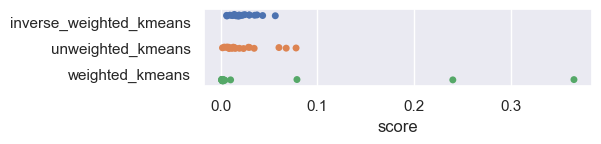

In [27]:
sns.set(rc={"figure.figsize":(5, 1)})
ax = sns.stripplot(x='score', y='weighting', data=cluster_means, jitter=True, hue='weighting', dodge=True, legend=False)
ax.set(ylabel=None)

In [28]:
cluster_means[['weighting', 'score']].groupby('weighting').std() # standard deviation of mean scores across clusters

,score
weighting,
inverse_weighted_kmeans,0.012930
unweighted_kmeans,0.021745
weighted_kmeans,0.094925


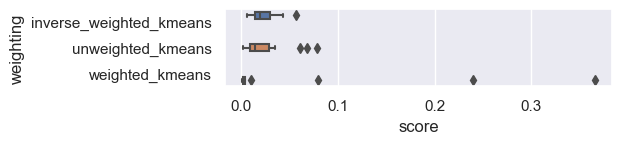

In [29]:
g = sns.boxplot(x='score', y ='weighting', data = cluster_means, hue ='weighting')
g.legend([],[], frameon=False)

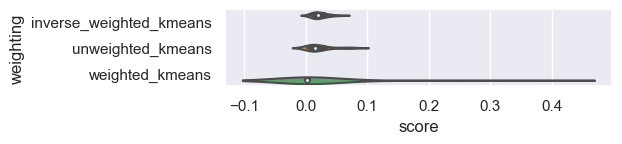

In [30]:
g = sns.violinplot(x ='score', y ='weighting', data = cluster_means, hue='weighting', legend=False)
g.legend([],[], frameon=False)

In [31]:
# cs_inverse_weighted.plot.scatter(x='cluster_id', y='score_mean')
# cs_unweighted.plot.scatter(x='cluster_id', y='score_mean')

# plt.scatter(cs_unweighted['cluster_id'], cs_inverse_weighted['score_mean'], c='r')
# plt.scatter(cs_weighted['cluster_id'], cs_inverse_weighted['score_mean'], c='g')
# plt.scatter(cs_inverse_weighted['cluster_id'], cs_inverse_weighted['score_mean'], c='b')

In [32]:
cs_inverse_weighted

,cluster_id,score_mean,score_std
0,0,0.019663,0.105115
1,1,0.043521,0.141821
2,2,0.011683,0.069329
3,3,0.029693,0.113970
4,4,0.012433,0.082562
5,5,0.019228,0.104877
6,6,0.025065,0.114387
7,7,0.015858,0.086038
8,8,0.017849,0.105170
9,9,0.019158,0.091901


In [36]:
get_cluster_stats(dd2, 'unweighted_kmeans', 'score')

,cluster_id,score_mean,score_std
0,0,0.023779,0.118271
1,1,0.008770,0.056579
2,2,0.028884,0.122279
3,3,0.001978,0.003171
4,4,0.015174,0.085942
5,5,0.005647,0.035495
6,6,0.029759,0.114686
7,7,0.008826,0.060396
8,8,0.067880,0.192872
9,9,0.019497,0.101948


In [37]:
get_cluster_stats(dd2, 'weighted_kmeans', 'score')

,cluster_id,score_mean,score_std
0,0,0.001195,0.003338
1,1,0.001476,0.006262
2,2,0.001345,0.002795
3,3,0.001771,0.006142
4,4,0.001552,0.002931
5,5,0.001567,0.003780
6,6,0.240227,0.264098
7,7,0.079017,0.169674
8,8,0.365534,0.342555
9,9,0.003883,0.004281


In [35]:
get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

,cluster_id,score_mean,score_std
0,0,0.019663,0.105115
1,1,0.043521,0.141821
2,2,0.011683,0.069329
3,3,0.029693,0.113970
4,4,0.012433,0.082562
5,5,0.019228,0.104877
6,6,0.025065,0.114387
7,7,0.015858,0.086038
8,8,0.017849,0.105170
9,9,0.019158,0.091901


In [74]:
def plot_model_means_for_reweighted_clusters(target_model='instruction_sports', vector_col='instruction_vector', n_clusters=20, seed=0):

    clf = models[target_model]['model']
    
    # dd2 = utils.add_cluster_cols(dolly_data, embedding_col='instruction_vector', prefix='unweighted_cl', letters='A', max_threshold=10)
    dd2['score'] = clf.predict_proba( X = [v for v in dolly_data[vector_col]] )[:,1]
    dd2['weighted_instruction_vector'] = [ v * clf.coef_[0] for v in dolly_data[vector_col]]
    dd2['inverse_weighted_instruction_vector'] = [ v / clf.coef_[0] for v in dolly_data[vector_col]]
    
    unweighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['instruction_vector']])
    weighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['weighted_instruction_vector']])
    inverse_weighted_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dd2['inverse_weighted_instruction_vector']])
    
    dd2['unweighted_kmeans'] = unweighted_kmeans.labels_
    dd2['weighted_kmeans'] = weighted_kmeans.labels_
    dd2['inverse_weighted_kmeans'] = inverse_weighted_kmeans.labels_
    
    dd3 = dd2[ ['unweighted_kmeans', 'weighted_kmeans', 'inverse_weighted_kmeans', 'score'] ] # 
    
    dd3_long = pd.melt(dd3, id_vars=['score'], var_name='weighting', value_name='cluster_id')
    
    cluster_means = dd3_long.groupby(["weighting", "cluster_id"]).mean().reset_index()
    
    sns.set(rc={"figure.figsize":(5, 1)})
    ax = sns.stripplot(x='score', y='weighting', data=cluster_means, jitter=True, hue='weighting', dodge=True, legend=False)
    ax.set(ylabel=None)
    ax.set(title=target_model)
    plt.show()


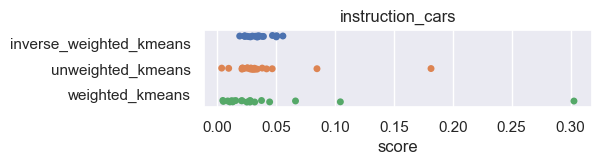

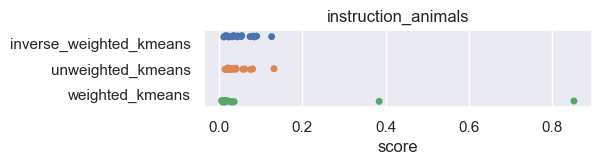

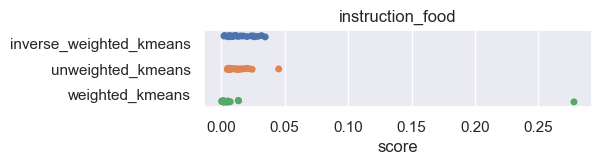

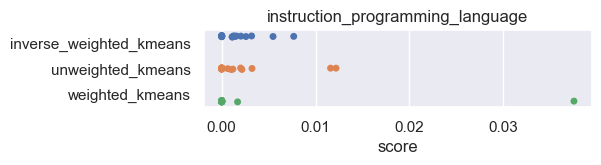

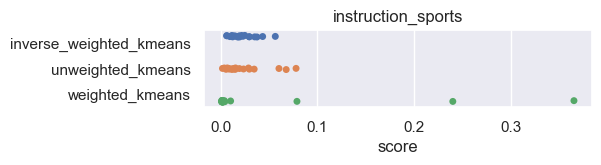

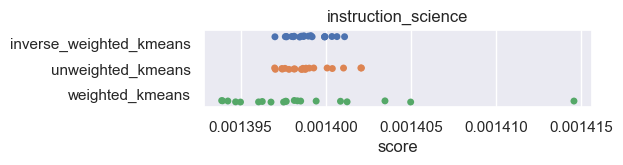

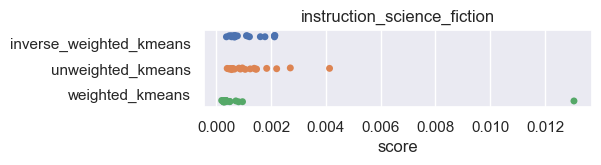

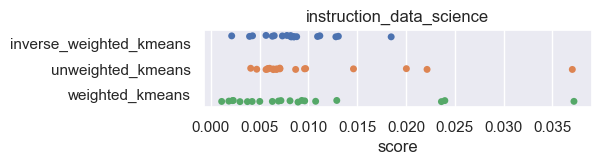

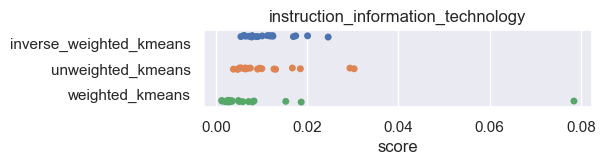

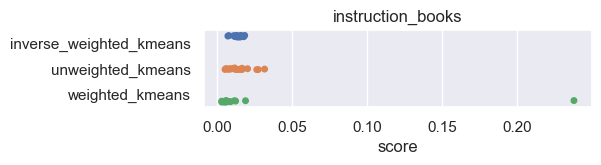

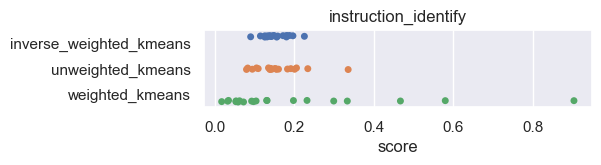

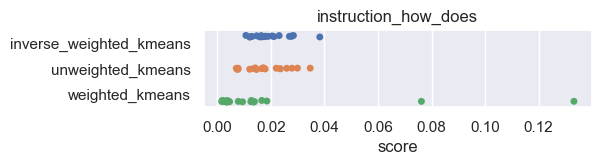

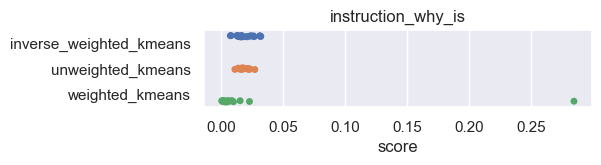

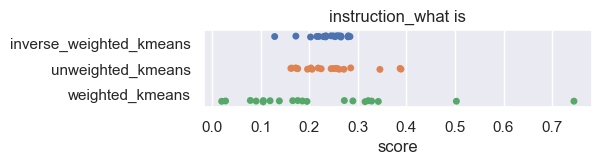

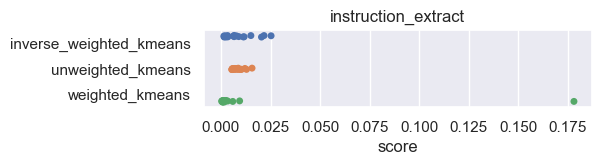

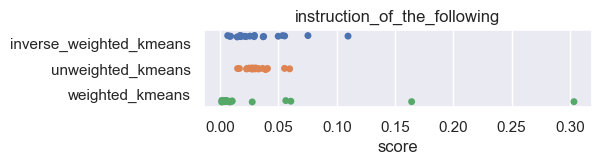

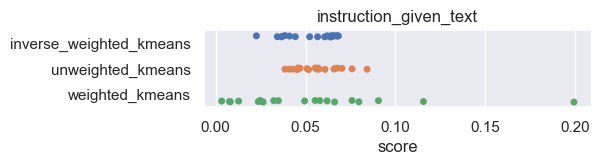

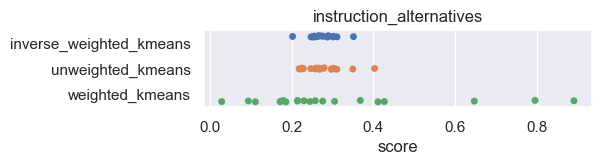

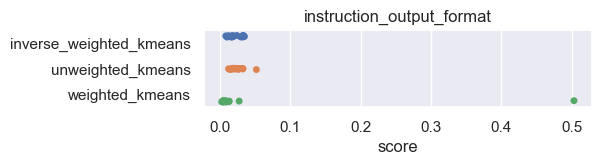

In [84]:
instruction_models = [k for k in models.keys() if k.startswith('instruction_')]
for target_model in instruction_models:
    plot_model_means_for_reweighted_clusters(target_model)

number of coefficients: 384


-2.7399335326010386

['inverse_weighted_cl_A', 'inverse_weighted_cl_B', 'inverse_weighted_cl_C']